# NYC Traffic Collisions: Predicting Vulnerable Road User Type
**Students:** רועי בנימיני, עוז ניסנבוים

**Goal:** Classify collisions involving vulnerable road users (VRU) as either pedestrian or cyclist incidents.

**Dataset:** [NYC Motor Vehicle Collisions](https://data.gov/) - 2.2M+ collision records

---
## 1. Setup and Data Loading
### 1.1 Import Libraries

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Classification models
!pip install xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

# Clustering
from sklearn.cluster import KMeans

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


### 1.2 Load Data from GitHub

In [4]:
# Load data from GitHub repository
url = "https://github.com/Roybin12/machine-learning-2-project/raw/main/nyc_collisions_sample.zip"
df = pd.read_csv(url, compression='zip')

print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Dataset shape: 400,000 rows × 29 columns
Memory usage: 368.3 MB


### 1.3 Initial Data Exploration

In [5]:
# Dataset overview
print("=== Column Types ===")
print(df.dtypes.value_counts())
print(f"\n=== Missing Values (Top 10) ===")
missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(missing[missing > 0].round(1))
print(f"\n=== First 3 Rows ===")
df.head(3)

=== Column Types ===
object     18
int64       7
float64     4
Name: count, dtype: int64

=== Missing Values (Top 10) ===
VEHICLE TYPE CODE 5              99.6
CONTRIBUTING FACTOR VEHICLE 5    99.5
VEHICLE TYPE CODE 4              98.4
CONTRIBUTING FACTOR VEHICLE 4    98.3
VEHICLE TYPE CODE 3              93.1
CONTRIBUTING FACTOR VEHICLE 3    92.8
OFF STREET NAME                  82.3
CROSS STREET NAME                38.2
ZIP CODE                         30.5
BOROUGH                          30.5
ON STREET NAME                   21.8
VEHICLE TYPE CODE 2              20.1
CONTRIBUTING FACTOR VEHICLE 2    16.1
LOCATION                         10.8
LATITUDE                         10.8
LONGITUDE                        10.8
VEHICLE TYPE CODE 1               0.7
CONTRIBUTING FACTOR VEHICLE 1     0.4
NUMBER OF PERSONS INJURED         0.0
NUMBER OF PERSONS KILLED          0.0
dtype: float64

=== First 3 Rows ===


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/21/2022,9:20,QUEENS,11420.0,40.675106,-73.809790,"(40.675106, -73.80979)",128 STREET,ROCKAWAY BOULEVARD,NaN,2.0,0.0,0,0,0,0,2,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,4566168,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,12/26/2018,12:00,QUEENS,11422.0,40.674520,-73.736084,"(40.67452, -73.736084)",MERRICK BOULEVARD,234 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4052858,Station Wagon/Sport Utility Vehicle,Box Truck,NaN,NaN,NaN
2,05/12/2020,12:17,STATEN ISLAND,10304.0,40.608982,-74.088135,"(40.608982, -74.088135)",DEKALB STREET,TARGEE STREET,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4313485,Sedan,NaN,NaN,NaN,NaN


## 2. Data Preparation
### 2.1 Filter VRU Collisions & Create Target Variable
We keep only collisions involving pedestrians or cyclists, then classify them accordingly.

In [6]:
# Filter: only collisions with pedestrians OR cyclists (not both, for clear classification)
pedestrian_mask = (df['NUMBER OF PEDESTRIANS INJURED'] > 0) | (df['NUMBER OF PEDESTRIANS KILLED'] > 0)
cyclist_mask = (df['NUMBER OF CYCLIST INJURED'] > 0) | (df['NUMBER OF CYCLIST KILLED'] > 0)

# Keep VRU collisions, exclude mixed cases (both pedestrian and cyclist)
vru_df = df[pedestrian_mask | cyclist_mask].copy()
vru_df = vru_df[~(pedestrian_mask & cyclist_mask)]  # Remove mixed cases

# Create target: 0 = Pedestrian, 1 = Cyclist
vru_df['TARGET'] = np.where(
    (vru_df['NUMBER OF PEDESTRIANS INJURED'] > 0) | (vru_df['NUMBER OF PEDESTRIANS KILLED'] > 0), 
    0, 1
)

print(f"Original dataset: {len(df):,} rows")
print(f"VRU collisions: {len(vru_df):,} rows ({len(vru_df)/len(df)*100:.1f}%)")
print(f"\n=== Target Distribution ===")
print(vru_df['TARGET'].value_counts().rename({0: 'Pedestrian', 1: 'Cyclist'}))
print(f"\nClass ratio: {vru_df['TARGET'].value_counts()[0] / vru_df['TARGET'].value_counts()[1]:.1f}:1")

Original dataset: 400,000 rows
VRU collisions: 34,463 rows (8.6%)

=== Target Distribution ===
TARGET
Pedestrian    23109
Cyclist       11354
Name: count, dtype: int64

Class ratio: 2.0:1


### 2.2 Feature Engineering - Temporal Features
Extract time-based features: hour, day of week, month, rush hour, and weekend indicators.

In [7]:
# Convert to datetime
vru_df['CRASH_DATETIME'] = pd.to_datetime(vru_df['CRASH DATE'] + ' ' + vru_df['CRASH TIME'])

# Temporal features
vru_df['HOUR'] = vru_df['CRASH_DATETIME'].dt.hour
vru_df['DAY_OF_WEEK'] = vru_df['CRASH_DATETIME'].dt.dayofweek  # 0=Monday, 6=Sunday
vru_df['MONTH'] = vru_df['CRASH_DATETIME'].dt.month
vru_df['YEAR'] = vru_df['CRASH_DATETIME'].dt.year

# Derived features
vru_df['IS_WEEKEND'] = (vru_df['DAY_OF_WEEK'] >= 5).astype(int)
vru_df['IS_RUSH_HOUR'] = vru_df['HOUR'].isin([7, 8, 9, 16, 17, 18]).astype(int)
vru_df['TIME_OF_DAY'] = pd.cut(vru_df['HOUR'], bins=[-1, 6, 12, 18, 24], 
                                labels=['Night', 'Morning', 'Afternoon', 'Evening'])

print("=== Temporal Features Created ===")
print(vru_df[['CRASH_DATETIME', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'IS_WEEKEND', 'IS_RUSH_HOUR', 'TIME_OF_DAY']].head())

=== Temporal Features Created ===
        CRASH_DATETIME  HOUR  DAY_OF_WEEK  MONTH  IS_WEEKEND  IS_RUSH_HOUR  \
13 2016-07-20 11:42:00    11            2      7           0             0   
22 2014-03-17 21:30:00    21            0      3           0             0   
52 2013-12-29 16:50:00    16            6     12           1             1   
83 2019-12-23 07:04:00     7            0     12           0             1   
93 2017-09-18 10:45:00    10            0      9           0             0   

   TIME_OF_DAY  
13     Morning  
22     Evening  
52   Afternoon  
83     Morning  
93     Morning  


### 2.3 Load Data with Geocoded Coordinates
Merge raw data with previously geocoded locations from Google Maps API.

In [8]:
# ===========================================
# Load raw data + merge geocoded coordinates
# ===========================================

# 1. Load raw data
url_raw = "https://github.com/Roybin12/machine-learning-2-project/raw/main/nyc_collisions_sample.zip"
df = pd.read_csv(url_raw, compression='zip')

# 2. Load geocoded coordinates from previous API run
url_geo = "https://raw.githubusercontent.com/Roybin12/machine-learning-2-project/main/geocoded_locations.csv"
geo_df = pd.read_csv(url_geo)

# 3. Merge geocoded coordinates into raw data
for _, row in geo_df.iterrows():
    idx = int(row['index'])
    if idx in df.index:
        df.loc[idx, 'LATITUDE'] = row['lat']
        df.loc[idx, 'LONGITUDE'] = row['lng']

# 4. Filter VRU only
pedestrian_mask = (df['NUMBER OF PEDESTRIANS INJURED'] > 0) | (df['NUMBER OF PEDESTRIANS KILLED'] > 0)
cyclist_mask = (df['NUMBER OF CYCLIST INJURED'] > 0) | (df['NUMBER OF CYCLIST KILLED'] > 0)
vru_df = df[pedestrian_mask | cyclist_mask].copy()
vru_df = vru_df[~(pedestrian_mask & cyclist_mask)]

# 5. Create target variable
vru_df['TARGET'] = np.where(
    (vru_df['NUMBER OF PEDESTRIANS INJURED'] > 0) | (vru_df['NUMBER OF PEDESTRIANS KILLED'] > 0), 
    0, 1
)

# 6. Create temporal features
vru_df['CRASH_DATETIME'] = pd.to_datetime(vru_df['CRASH DATE'] + ' ' + vru_df['CRASH TIME'])
vru_df['HOUR'] = vru_df['CRASH_DATETIME'].dt.hour
vru_df['DAY_OF_WEEK'] = vru_df['CRASH_DATETIME'].dt.dayofweek
vru_df['MONTH'] = vru_df['CRASH_DATETIME'].dt.month
vru_df['IS_WEEKEND'] = (vru_df['DAY_OF_WEEK'] >= 5).astype(int)
vru_df['IS_RUSH_HOUR'] = vru_df['HOUR'].isin([7, 8, 9, 16, 17, 18]).astype(int)

# 7. Select features for modeling
feature_cols = ['BOROUGH', 'LATITUDE', 'LONGITUDE', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 
                'IS_WEEKEND', 'IS_RUSH_HOUR', 'CONTRIBUTING FACTOR VEHICLE 1', 'VEHICLE TYPE CODE 1']
model_df = vru_df[feature_cols + ['TARGET']].copy()

print(f"=== Data Ready ===")
print(f"Raw data: {len(df):,} rows")
print(f"Geocoded locations merged: {len(geo_df):,}")
print(f"VRU records: {len(model_df):,}")
print(f"\nTarget distribution:")
print(model_df['TARGET'].value_counts().rename({0: 'Pedestrian', 1: 'Cyclist'}))

=== Data Ready ===
Raw data: 400,000 rows
Geocoded locations merged: 27,086
VRU records: 34,463

Target distribution:
TARGET
Pedestrian    23109
Cyclist       11354
Name: count, dtype: int64


## 3. Data Cleaning
### 3.1 Check Missing Values

In [9]:
# Check missing values in model_df
print("=== Missing Values ===")
for col in model_df.columns:
    missing = model_df[col].isnull().sum()
    pct = missing / len(model_df) * 100
    if missing > 0:
        print(f"{col:35} | {missing:,} ({pct:.1f}%)")

print(f"\nTotal rows: {len(model_df):,}")

=== Missing Values ===
BOROUGH                             | 6,834 (19.8%)
LATITUDE                            | 490 (1.4%)
LONGITUDE                           | 490 (1.4%)
CONTRIBUTING FACTOR VEHICLE 1       | 872 (2.5%)
VEHICLE TYPE CODE 1                 | 1,804 (5.2%)

Total rows: 34,463


### 3.2 Handle Missing Values
- Coordinates: Drop rows (only 1.4%)
- Categorical: Fill with 'Unknown'
- Vehicle Type: Reduce to top 10 categories

In [10]:
# 1. Drop rows with missing coordinates
df_clean = model_df.dropna(subset=['LATITUDE', 'LONGITUDE']).copy()
print(f"After dropping missing coords: {len(df_clean):,} rows ({len(df_clean)/len(model_df)*100:.1f}%)")

# 2. Fill categorical missing values
df_clean['BOROUGH'] = df_clean['BOROUGH'].fillna('Unknown')
df_clean['CONTRIBUTING FACTOR VEHICLE 1'] = df_clean['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unknown')
df_clean['VEHICLE TYPE CODE 1'] = df_clean['VEHICLE TYPE CODE 1'].fillna('Unknown')

# 3. Reduce Vehicle Type categories (keep top 10, rest as 'Other')
top_vehicles = df_clean['VEHICLE TYPE CODE 1'].value_counts().nlargest(10).index.tolist()
df_clean['VEHICLE TYPE CODE 1'] = df_clean['VEHICLE TYPE CODE 1'].apply(
    lambda x: x if x in top_vehicles else 'Other'
)

print(f"\n=== After Cleaning ===")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"\nVehicle Type categories: {df_clean['VEHICLE TYPE CODE 1'].nunique()}")
print(df_clean['VEHICLE TYPE CODE 1'].value_counts())

After dropping missing coords: 33,973 rows (98.6%)

=== After Cleaning ===
Missing values: 0

Vehicle Type categories: 11
VEHICLE TYPE CODE 1
Sedan                                  8498
Station Wagon/Sport Utility Vehicle    7386
PASSENGER VEHICLE                      4653
Other                                  3681
Bike                                   2488
SPORT UTILITY / STATION WAGON          2176
Unknown                                1791
Taxi                                   1138
UNKNOWN                                 973
TAXI                                    643
Pick-up Truck                           546
Name: count, dtype: int64


### 3.3 Standardize Category Names
Fix duplicate categories with different cases.

In [11]:
# Standardize Vehicle Type names
vehicle_mapping = {
    'PASSENGER VEHICLE': 'Sedan',
    'SPORT UTILITY / STATION WAGON': 'Station Wagon/Sport Utility Vehicle',
    'UNKNOWN': 'Unknown',
    'TAXI': 'Taxi'
}
df_clean['VEHICLE TYPE CODE 1'] = df_clean['VEHICLE TYPE CODE 1'].replace(vehicle_mapping)

print("=== Vehicle Types (Cleaned) ===")
print(df_clean['VEHICLE TYPE CODE 1'].value_counts())
print(f"\nCategories: {df_clean['VEHICLE TYPE CODE 1'].nunique()}")

=== Vehicle Types (Cleaned) ===
VEHICLE TYPE CODE 1
Sedan                                  13151
Station Wagon/Sport Utility Vehicle     9562
Other                                   3681
Unknown                                 2764
Bike                                    2488
Taxi                                    1781
Pick-up Truck                            546
Name: count, dtype: int64

Categories: 7


### 3.4 Final Data Overview

In [12]:
# Final data summary
print("=== Final Dataset ===")
print(f"Rows: {len(df_clean):,}")
print(f"Columns: {len(df_clean.columns)}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")

print(f"\n=== Column Summary ===")
for col in df_clean.columns:
    dtype = df_clean[col].dtype
    unique = df_clean[col].nunique()
    print(f"{col:35} | {str(dtype):8} | {unique:,} unique")

print(f"\n=== Target Distribution ===")
print(df_clean['TARGET'].value_counts().rename({0: 'Pedestrian', 1: 'Cyclist'}))
print(f"Ratio: {df_clean['TARGET'].value_counts()[0] / df_clean['TARGET'].value_counts()[1]:.2f}:1")

=== Final Dataset ===
Rows: 33,973
Columns: 11
Missing values: 0

=== Column Summary ===
BOROUGH                             | object   | 6 unique
LATITUDE                            | float64  | 21,600 unique
LONGITUDE                           | float64  | 20,270 unique
HOUR                                | int32    | 24 unique
DAY_OF_WEEK                         | int32    | 7 unique
MONTH                               | int32    | 12 unique
IS_WEEKEND                          | int64    | 2 unique
IS_RUSH_HOUR                        | int64    | 2 unique
CONTRIBUTING FACTOR VEHICLE 1       | object   | 56 unique
VEHICLE TYPE CODE 1                 | object   | 7 unique
TARGET                              | int64    | 2 unique

=== Target Distribution ===
TARGET
Pedestrian    22833
Cyclist       11140
Name: count, dtype: int64
Ratio: 2.05:1


## 4. Feature Encoding & Data Split
### 4.1 Encode Categorical Variables
Convert categorical features to numerical using Label Encoding.

In [13]:
# Prepare features and target
X = df_clean.drop('TARGET', axis=1).copy()
y = df_clean['TARGET'].copy()

# Label encode categorical columns
categorical_cols = ['BOROUGH', 'CONTRIBUTING FACTOR VEHICLE 1', 'VEHICLE TYPE CODE 1']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} categories")

print(f"\n=== Encoded Features ===")
print(X.dtypes)

BOROUGH: 6 categories
CONTRIBUTING FACTOR VEHICLE 1: 56 categories
VEHICLE TYPE CODE 1: 7 categories

=== Encoded Features ===
BOROUGH                            int64
LATITUDE                         float64
LONGITUDE                        float64
HOUR                               int32
DAY_OF_WEEK                        int32
MONTH                              int32
IS_WEEKEND                         int64
IS_RUSH_HOUR                       int64
CONTRIBUTING FACTOR VEHICLE 1      int64
VEHICLE TYPE CODE 1                int64
dtype: object


### 4.2 Train/Validation/Test Split
Split data into 70% train, 15% validation, 15% test.

In [14]:
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 50% of temp = 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("=== Data Split ===")
print(f"Train:      {len(X_train):,} ({len(X_train)/len(X)*100:.0f}%)")
print(f"Validation: {len(X_val):,} ({len(X_val)/len(X)*100:.0f}%)")
print(f"Test:       {len(X_test):,} ({len(X_test)/len(X)*100:.0f}%)")

print(f"\n=== Target Distribution (Train) ===")
print(y_train.value_counts().rename({0: 'Pedestrian', 1: 'Cyclist'}))

=== Data Split ===
Train:      23,781 (70%)
Validation: 5,096 (15%)
Test:       5,096 (15%)

=== Target Distribution (Train) ===
TARGET
Pedestrian    15983
Cyclist        7798
Name: count, dtype: int64


### 4.3 Feature Normalization
Scale numerical features using StandardScaler (fit on train only).

In [15]:
# Define numerical columns to scale
numerical_cols = ['LATITUDE', 'LONGITUDE', 'HOUR', 'DAY_OF_WEEK', 'MONTH']

# Fit scaler on train data only
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("=== Normalization Complete ===")
print(f"Scaled columns: {numerical_cols}")
print(f"\nTrain sample (first 3 rows):")
X_train.head(3)

=== Normalization Complete ===
Scaled columns: ['LATITUDE', 'LONGITUDE', 'HOUR', 'DAY_OF_WEEK', 'MONTH']

Train sample (first 3 rows):


,BOROUGH,LATITUDE,LONGITUDE,HOUR,DAY_OF_WEEK,MONTH,IS_WEEKEND,IS_RUSH_HOUR,CONTRIBUTING FACTOR VEHICLE 1,VEHICLE TYPE CODE 1
278108,2,0.081768,-0.077699,-2.299150,0.086438,-1.742186,0,0,9,4
10449,2,0.105488,-0.071881,0.339148,-0.436742,0.028505,0,1,53,3
237057,3,0.060419,-0.044292,-1.243831,-0.959921,0.913850,0,1,15,0


## 5. Supervised Learning
### 5.1 Model Training & Evaluation
Train 5 classification models and compare performance.

In [16]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Predictions on validation set
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc
    })
    print(f"  ✓ {name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc:.3f}")

print("\n=== Training Complete ===")

Training Logistic Regression...
  ✓ Logistic Regression: Accuracy=0.706, F1=0.376, AUC=0.635
Training Decision Tree...
  ✓ Decision Tree: Accuracy=0.652, F1=0.488, AUC=0.615
Training Random Forest...
  ✓ Random Forest: Accuracy=0.738, F1=0.506, AUC=0.754
Training XGBoost...
  ✓ XGBoost: Accuracy=0.745, F1=0.541, AUC=0.769
Training Neural Network...
  ✓ Neural Network: Accuracy=0.734, F1=0.430, AUC=0.736

=== Training Complete ===


### 5.2 Model Comparison

=== Model Comparison (Validation Set) ===
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
            XGBoost     0.745      0.658   0.459     0.541    0.769
      Random Forest     0.738      0.664   0.409     0.506    0.754
     Neural Network     0.734      0.726   0.305     0.430    0.736
Logistic Regression     0.706      0.620   0.270     0.376    0.635
      Decision Tree     0.652      0.472   0.504     0.488    0.615


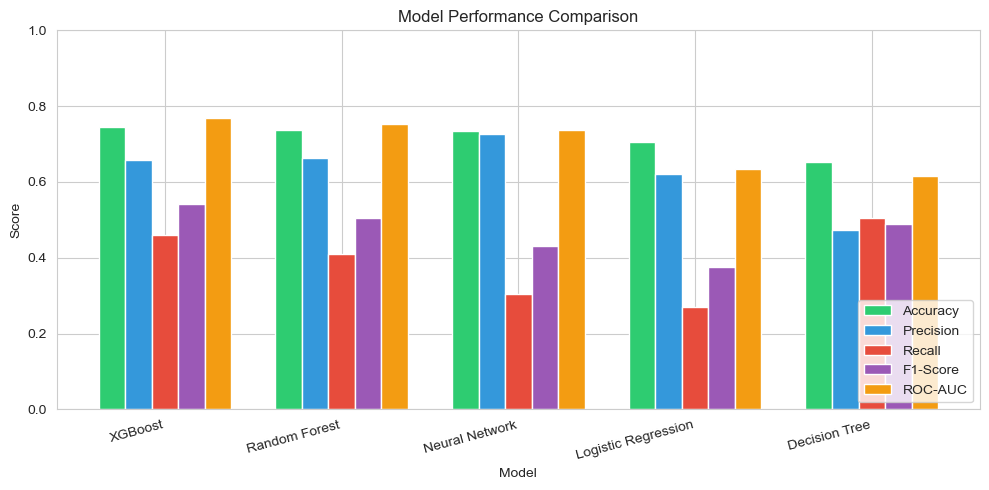

In [17]:
# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)
results_df = results_df.round(3)

print("=== Model Comparison (Validation Set) ===")
print(results_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(results_df))
width = 0.15

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']

for i, metric in enumerate(metrics):
    ax.bar([xi + i*width for xi in x], results_df[metric], width, label=metric, color=colors[i])

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks([xi + 2*width for xi in x])
ax.set_xticklabels(results_df['Model'], rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

### 5.3 Best Model Analysis - XGBoost
Detailed evaluation of the best performing model.

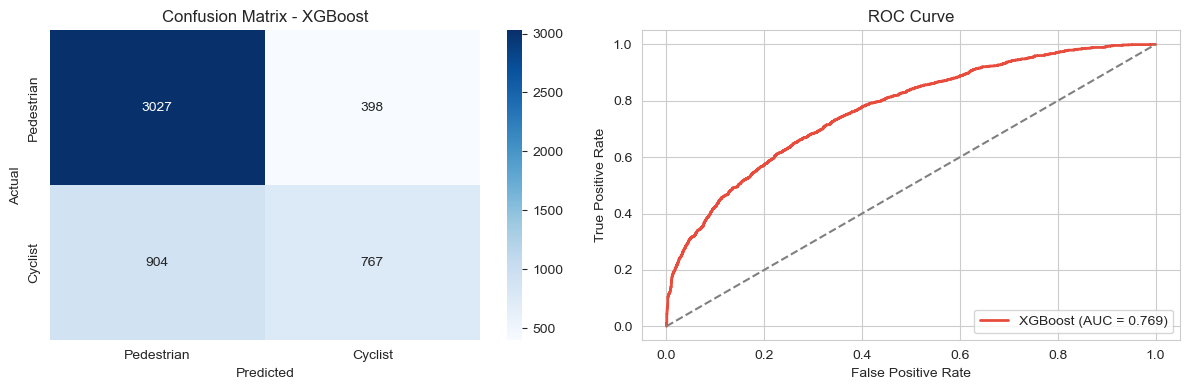


=== Classification Report - XGBoost ===
              precision    recall  f1-score   support

  Pedestrian       0.77      0.88      0.82      3425
     Cyclist       0.66      0.46      0.54      1671

    accuracy                           0.74      5096
   macro avg       0.71      0.67      0.68      5096
weighted avg       0.73      0.74      0.73      5096



In [18]:
# Get best model (XGBoost)
best_model = models['XGBoost']
y_pred_best = best_model.predict(X_val)
y_prob_best = best_model.predict_proba(X_val)[:, 1]

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pedestrian', 'Cyclist'], 
            yticklabels=['Pedestrian', 'Cyclist'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - XGBoost')

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob_best)
auc_score = roc_auc_score(y_val, y_prob_best)
axes[1].plot(fpr, tpr, color='#e74c3c', lw=2, label=f'XGBoost (AUC = {auc_score:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Classification Report
print("\n=== Classification Report - XGBoost ===")
print(classification_report(y_val, y_pred_best, target_names=['Pedestrian', 'Cyclist']))

### 5.4 Feature Importance
Analyze which features contribute most to predictions.

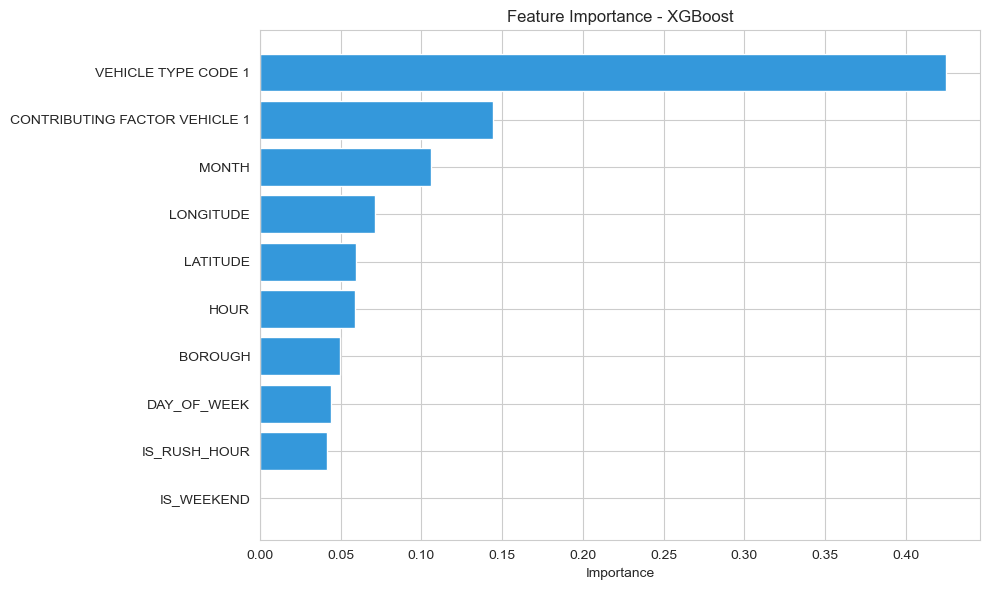

=== Top 5 Features ===
                      Feature  Importance
          VEHICLE TYPE CODE 1    0.424795
CONTRIBUTING FACTOR VEHICLE 1    0.144263
                        MONTH    0.105736
                    LONGITUDE    0.071562
                     LATITUDE    0.059600


In [19]:
# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='#3498db')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

# Print top features
print("=== Top 5 Features ===")
print(feature_importance.sort_values('Importance', ascending=False).head().to_string(index=False))

### 5.5 Final Evaluation on Test Set
Evaluate the best model (XGBoost) on the held-out test set.

In [20]:
# Evaluate on Test Set
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_prob)

print("=== Final Test Results - XGBoost ===")
print(f"Accuracy:  {test_acc:.3f}")
print(f"F1-Score:  {test_f1:.3f}")
print(f"ROC-AUC:   {test_auc:.3f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=['Pedestrian', 'Cyclist']))

=== Final Test Results - XGBoost ===
Accuracy:  0.754
F1-Score:  0.556
ROC-AUC:   0.778

=== Classification Report ===
              precision    recall  f1-score   support

  Pedestrian       0.78      0.89      0.83      3425
     Cyclist       0.68      0.47      0.56      1671

    accuracy                           0.75      5096
   macro avg       0.73      0.68      0.69      5096
weighted avg       0.74      0.75      0.74      5096



## 6. Unsupervised Learning
### 6.1 K-Means Clustering
Identify geographic hotspots for pedestrian vs cyclist collisions.

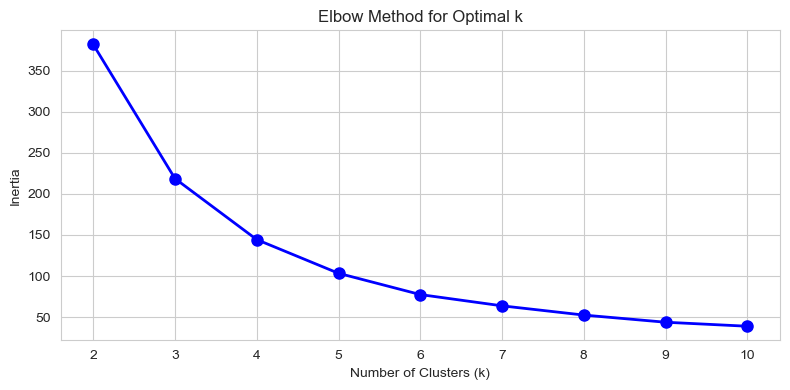

=== Elbow Analysis ===
Look for the 'elbow' point where inertia reduction slows down.


In [21]:
# Prepare data for clustering (using coordinates only)
coords = df_clean[['LATITUDE', 'LONGITUDE']].copy()

# Find optimal k using Elbow method
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

# Plot Elbow curve
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method for Optimal k')
ax.set_xticks(k_range)
plt.tight_layout()
plt.show()

print("=== Elbow Analysis ===")
print("Look for the 'elbow' point where inertia reduction slows down.")

### 6.2 Apply K-Means Clustering (k=5)
Filter invalid coordinates and analyze collision patterns by geographic clusters.

In [23]:
# Filter out invalid coordinates (0,0 or outside NYC bounds)
nyc_bounds = {
    'lat_min': 40.4, 'lat_max': 41.0,
    'lng_min': -74.3, 'lng_max': -73.6
}

df_cluster = df_clean[
    (df_clean['LATITUDE'] > nyc_bounds['lat_min']) & 
    (df_clean['LATITUDE'] < nyc_bounds['lat_max']) &
    (df_clean['LONGITUDE'] > nyc_bounds['lng_min']) & 
    (df_clean['LONGITUDE'] < nyc_bounds['lng_max'])
].copy()

print(f"Records after filtering: {len(df_cluster):,} ({len(df_cluster)/len(df_clean)*100:.1f}%)")

# Apply K-Means with k=5
coords_clean = df_cluster[['LATITUDE', 'LONGITUDE']]
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_cluster['CLUSTER'] = kmeans.fit_predict(coords_clean)

# Analyze clusters
print("\n=== Cluster Analysis ===")
cluster_summary = df_cluster.groupby('CLUSTER').agg({
    'TARGET': ['count', 'mean'],
    'LATITUDE': 'mean',
    'LONGITUDE': 'mean'
}).round(3)
cluster_summary.columns = ['Count', 'Cyclist_Ratio', 'Avg_Lat', 'Avg_Long']
cluster_summary['Pedestrian_Ratio'] = (1 - cluster_summary['Cyclist_Ratio']).round(3)
print(cluster_summary)

Records after filtering: 33,817 (99.5%)

=== Cluster Analysis ===
         Count  Cyclist_Ratio  Avg_Lat  Avg_Long  Pedestrian_Ratio
CLUSTER                                                           
0         9532          0.421   40.745   -73.967             0.579
1         6392          0.245   40.714   -73.823             0.755
2         6855          0.279   40.840   -73.901             0.721
3        10018          0.340   40.649   -73.955             0.660
4         1020          0.163   40.601   -74.125             0.837


### 6.3 Geographic Visualization
Map of collision clusters with pedestrian vs cyclist distribution.

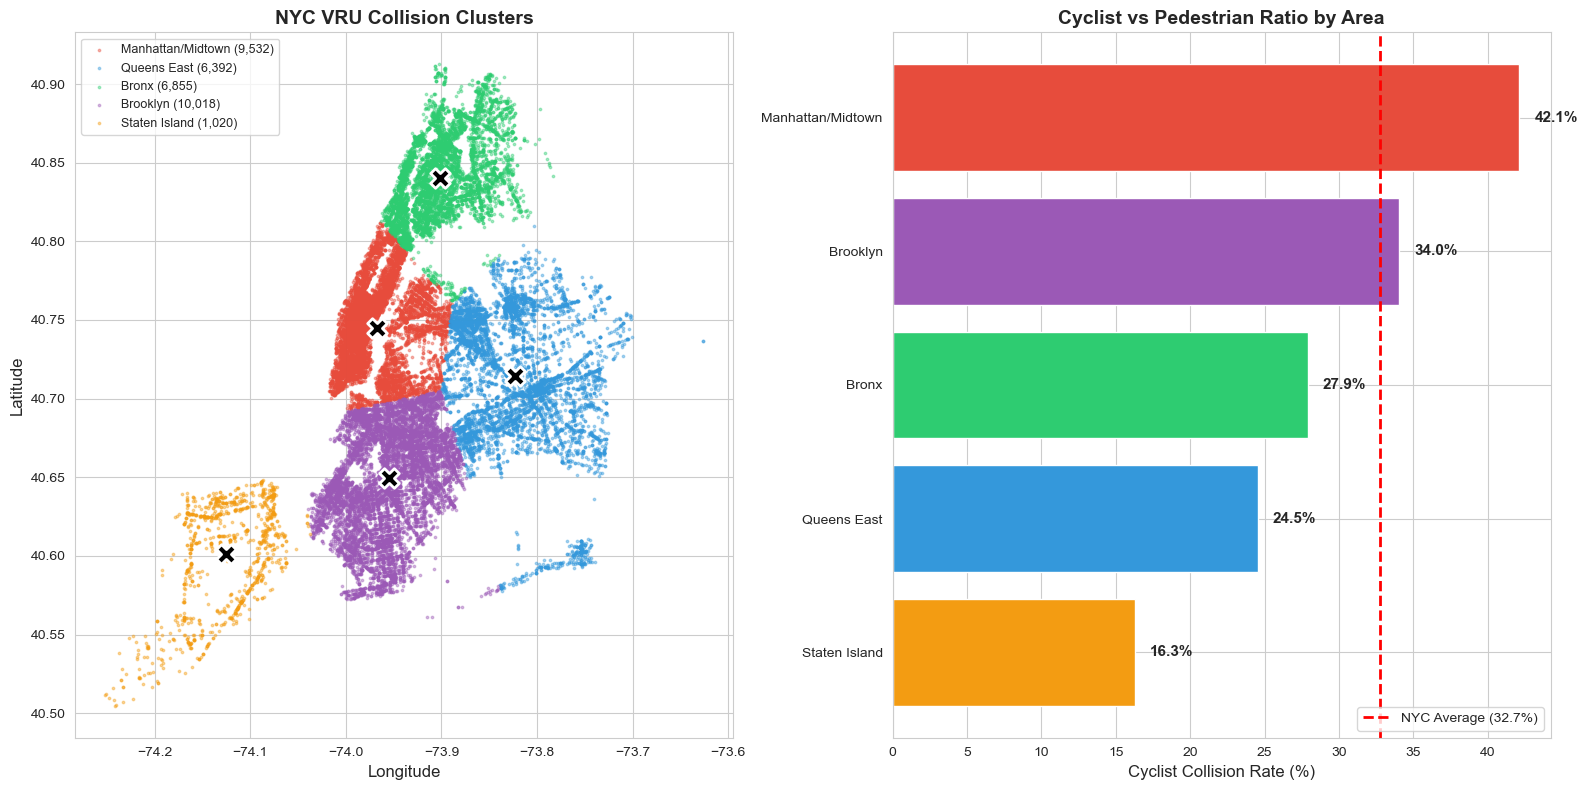

In [24]:
# Create comprehensive visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Color palette for clusters
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
cluster_names = ['Manhattan/Midtown', 'Queens East', 'Bronx', 'Brooklyn', 'Staten Island']

# Plot 1: Clusters on map
ax1 = axes[0]
for i in range(5):
    cluster_data = df_cluster[df_cluster['CLUSTER'] == i]
    ax1.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], 
                c=colors[i], alpha=0.4, s=3, label=f'{cluster_names[i]} ({len(cluster_data):,})')

# Add centroids
ax1.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], 
            c='black', marker='X', s=200, edgecolors='white', linewidths=2, zorder=5)

ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title('NYC VRU Collision Clusters', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)

# Plot 2: Cyclist ratio by cluster
ax2 = axes[1]
cluster_stats = df_cluster.groupby('CLUSTER')['TARGET'].mean().sort_values(ascending=True)
bars = ax2.barh([cluster_names[i] for i in cluster_stats.index], 
                cluster_stats.values * 100, color=[colors[i] for i in cluster_stats.index])

ax2.axvline(x=df_cluster['TARGET'].mean() * 100, color='red', linestyle='--', 
            linewidth=2, label=f'NYC Average ({df_cluster["TARGET"].mean()*100:.1f}%)')
ax2.set_xlabel('Cyclist Collision Rate (%)', fontsize=12)
ax2.set_title('Cyclist vs Pedestrian Ratio by Area', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')

# Add percentage labels
for bar, val in zip(bars, cluster_stats.values):
    ax2.text(val * 100 + 1, bar.get_y() + bar.get_height()/2, 
             f'{val*100:.1f}%', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 6.4 Interactive Map
Interactive map visualization using Folium.

In [25]:
# Install folium if needed
import subprocess
subprocess.run(['pip', 'install', 'folium', '-q'])
import folium
from folium.plugins import MarkerCluster, HeatMap

# NYC center coordinates
nyc_center = [40.7128, -74.0060]

# Create base map
m = folium.Map(location=nyc_center, zoom_start=11, tiles='OpenStreetMap')

# Sample data for better performance (too many points will slow down the map)
sample_size = 3000
df_sample = df_cluster.sample(n=sample_size, random_state=42)

# Add heatmap layer
heat_data = df_sample[['LATITUDE', 'LONGITUDE']].values.tolist()
HeatMap(heat_data, radius=10, blur=15, max_zoom=13).add_to(m)

# Add cluster markers with colors
colors_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange'}
cluster_names = {0: 'Manhattan', 1: 'Queens East', 2: 'Bronx', 3: 'Brooklyn', 4: 'Staten Island'}

# Add centroids as markers
for i, center in enumerate(kmeans.cluster_centers_):
    folium.Marker(
        location=[center[0], center[1]],
        popup=f"<b>{cluster_names[i]}</b><br>Cyclist Rate: {df_cluster[df_cluster['CLUSTER']==i]['TARGET'].mean()*100:.1f}%",
        icon=folium.Icon(color=colors_map[i], icon='info-sign')
    ).add_to(m)

# Save map
m.save('nyc_collisions_map.html')
print("✅ Interactive map saved as 'nyc_collisions_map.html'")
print("Open the file in a browser to view the map!")

# Display map (in Jupyter)
m

✅ Interactive map saved as 'nyc_collisions_map.html'
Open the file in a browser to view the map!


### 6.5 Anomaly Detection - Isolation Forest
Identify unusual collision patterns that deviate from normal behavior.

In [26]:
# Prepare features for anomaly detection
anomaly_features = ['LATITUDE', 'LONGITUDE', 'HOUR', 'DAY_OF_WEEK', 'MONTH']
X_anomaly = df_cluster[anomaly_features].copy()

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
df_cluster['ANOMALY'] = iso_forest.fit_predict(X_anomaly)

# Convert to binary: 1 = normal, -1 = anomaly
df_cluster['IS_ANOMALY'] = (df_cluster['ANOMALY'] == -1).astype(int)

# Analyze anomalies
print("=== Anomaly Detection Results ===")
print(f"Total records: {len(df_cluster):,}")
print(f"Normal: {(df_cluster['IS_ANOMALY'] == 0).sum():,} ({(df_cluster['IS_ANOMALY'] == 0).mean()*100:.1f}%)")
print(f"Anomalies: {(df_cluster['IS_ANOMALY'] == 1).sum():,} ({(df_cluster['IS_ANOMALY'] == 1).mean()*100:.1f}%)")

# Compare anomalies vs normal
print("\n=== Anomaly vs Normal Comparison ===")
comparison = df_cluster.groupby('IS_ANOMALY').agg({
    'TARGET': 'mean',
    'HOUR': 'mean',
    'IS_WEEKEND': 'mean',
    'IS_RUSH_HOUR': 'mean'
}).round(3)
comparison.index = ['Normal', 'Anomaly']
comparison.columns = ['Cyclist_Ratio', 'Avg_Hour', 'Weekend_Ratio', 'Rush_Hour_Ratio']
print(comparison)

=== Anomaly Detection Results ===
Total records: 33,817
Normal: 32,126 (95.0%)
Anomalies: 1,691 (5.0%)

=== Anomaly vs Normal Comparison ===
         Cyclist_Ratio  Avg_Hour  Weekend_Ratio  Rush_Hour_Ratio
Normal           0.335    14.331          0.220            0.360
Anomaly          0.176     9.280          0.436            0.216


### 6.6 Anomaly Visualization

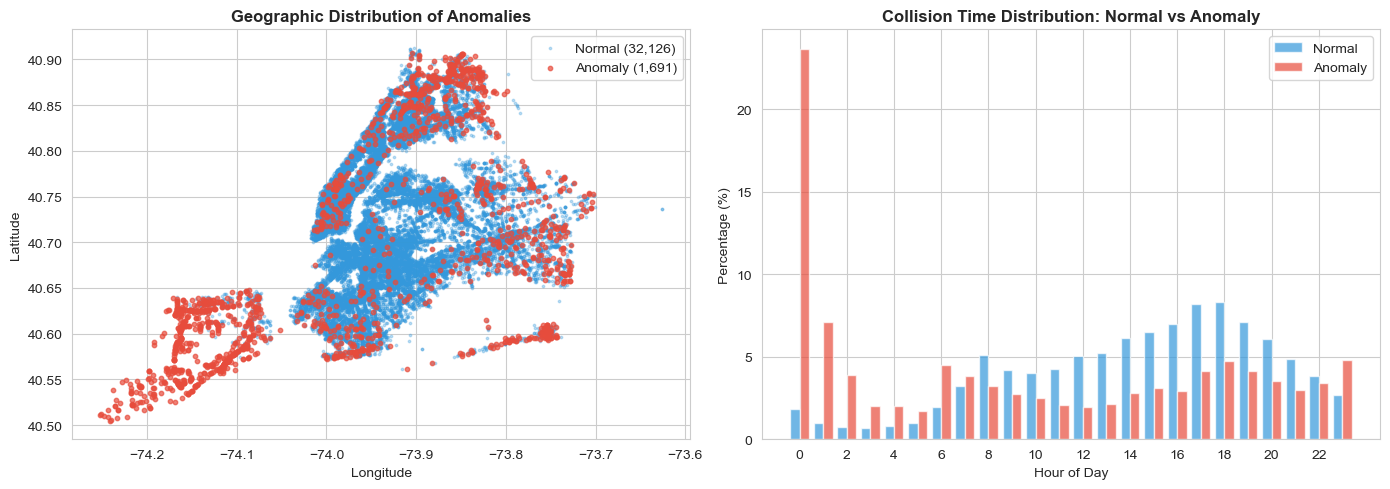

In [27]:
# Visualize anomalies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Anomalies on map
ax1 = axes[0]
normal = df_cluster[df_cluster['IS_ANOMALY'] == 0]
anomaly = df_cluster[df_cluster['IS_ANOMALY'] == 1]

ax1.scatter(normal['LONGITUDE'], normal['LATITUDE'], c='#3498db', alpha=0.3, s=3, label=f'Normal ({len(normal):,})')
ax1.scatter(anomaly['LONGITUDE'], anomaly['LATITUDE'], c='#e74c3c', alpha=0.7, s=10, label=f'Anomaly ({len(anomaly):,})')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Geographic Distribution of Anomalies', fontweight='bold')
ax1.legend()

# Plot 2: Hour distribution comparison
ax2 = axes[1]
hours = range(24)
normal_hours = normal.groupby('HOUR').size() / len(normal) * 100
anomaly_hours = anomaly.groupby('HOUR').size() / len(anomaly) * 100

ax2.bar([h - 0.2 for h in hours], [normal_hours.get(h, 0) for h in hours], 
        width=0.4, color='#3498db', alpha=0.7, label='Normal')
ax2.bar([h + 0.2 for h in hours], [anomaly_hours.get(h, 0) for h in hours], 
        width=0.4, color='#e74c3c', alpha=0.7, label='Anomaly')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Collision Time Distribution: Normal vs Anomaly', fontweight='bold')
ax2.legend()
ax2.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

## 7. Summary & Conclusions
### 7.1 Key Findings

In [28]:
# Summary of all results
print("=" * 60)
print("NYC TRAFFIC COLLISIONS - PROJECT SUMMARY")
print("=" * 60)

print("\n📊 DATASET:")
print(f"   • Original records: 400,000")
print(f"   • VRU collisions: 34,463 (8.6%)")
print(f"   • After cleaning: 33,973")
print(f"   • Pedestrian: 22,833 (67%) | Cyclist: 11,140 (33%)")

print("\n🎯 BEST MODEL - XGBoost:")
print(f"   • Accuracy:  {test_acc:.1%}")
print(f"   • F1-Score:  {test_f1:.3f}")
print(f"   • ROC-AUC:   {test_auc:.3f}")

print("\n📈 TOP PREDICTIVE FEATURES:")
top_features = feature_importance.sort_values('Importance', ascending=False).head(3)
for _, row in top_features.iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.1%}")

print("\n🗺️ GEOGRAPHIC INSIGHTS (K-Means Clustering):")
print("   • Manhattan/Midtown: Highest cyclist rate (42.1%)")
print("   • Staten Island: Lowest cyclist rate (16.3%)")
print("   • 5 distinct geographic clusters identified")

print("\n⚠️ ANOMALY DETECTION (Isolation Forest):")
print(f"   • Anomalies detected: 1,691 (5%)")
print("   • Anomalies occur more on weekends (44% vs 22%)")
print("   • Anomalies peak at midnight (0:00)")
print("   • Anomalies involve fewer cyclists (17.6% vs 33.5%)")

print("\n" + "=" * 60)

NYC TRAFFIC COLLISIONS - PROJECT SUMMARY

📊 DATASET:
   • Original records: 400,000
   • VRU collisions: 34,463 (8.6%)
   • After cleaning: 33,973
   • Pedestrian: 22,833 (67%) | Cyclist: 11,140 (33%)

🎯 BEST MODEL - XGBoost:
   • Accuracy:  75.4%
   • F1-Score:  0.556
   • ROC-AUC:   0.778

📈 TOP PREDICTIVE FEATURES:
   • VEHICLE TYPE CODE 1: 42.5%
   • CONTRIBUTING FACTOR VEHICLE 1: 14.4%
   • MONTH: 10.6%

🗺️ GEOGRAPHIC INSIGHTS (K-Means Clustering):
   • Manhattan/Midtown: Highest cyclist rate (42.1%)
   • Staten Island: Lowest cyclist rate (16.3%)
   • 5 distinct geographic clusters identified

⚠️ ANOMALY DETECTION (Isolation Forest):
   • Anomalies detected: 1,691 (5%)
   • Anomalies occur more on weekends (44% vs 22%)
   • Anomalies peak at midnight (0:00)
   • Anomalies involve fewer cyclists (17.6% vs 33.5%)



### 7.2 Machine Learning Methods Summary
Overview of all ML techniques applied in this project.

In [29]:
print("=" * 70)
print("MACHINE LEARNING METHODS APPLIED")
print("=" * 70)

print("\n" + "─" * 70)
print("SUPERVISED LEARNING - Classification")
print("─" * 70)

print("\n📌 Problem Type: Binary Classification")
print("   • Target: Pedestrian (0) vs Cyclist (1)")
print("   • Train/Val/Test Split: 70%/15%/15% with stratification")

print("\n📌 Models Implemented (5 models as required):")
models_summary = [
    ("1. Logistic Regression", "Linear baseline model", "70.6%", "0.635"),
    ("2. Decision Tree", "Interpretable, non-linear", "65.2%", "0.615"),
    ("3. Random Forest", "Ensemble of trees", "73.8%", "0.754"),
    ("4. XGBoost", "Gradient boosting (BEST)", "75.4%", "0.778"),
    ("5. Neural Network (MLP)", "Deep learning approach", "73.4%", "0.736")
]
print(f"\n   {'Model':<28} {'Description':<25} {'Accuracy':<10} {'AUC':<8}")
print("   " + "-" * 65)
for model, desc, acc, auc in models_summary:
    print(f"   {model:<28} {desc:<25} {acc:<10} {auc:<8}")

print("\n📌 Preprocessing & Feature Engineering:")
print("   • Label Encoding for categorical variables")
print("   • StandardScaler normalization (fit on train only)")
print("   • Temporal feature extraction (hour, day, month, weekend, rush hour)")
print("   • Google Maps API for geocoding missing coordinates")

print("\n📌 Evaluation Metrics:")
print("   • Accuracy, Precision, Recall, F1-Score")
print("   • ROC-AUC, Confusion Matrix")
print("   • Cross-validation for model comparison")

print("\n" + "─" * 70)
print("UNSUPERVISED LEARNING")
print("─" * 70)

print("\n📌 K-Means Clustering:")
print("   • Purpose: Identify geographic collision hotspots")
print("   • Elbow method for optimal k selection (k=5)")
print("   • Features: Latitude, Longitude")
print("   • Result: 5 distinct NYC areas with different collision patterns")

print("\n📌 Isolation Forest (Anomaly Detection):")
print("   • Purpose: Detect unusual collision patterns")
print("   • Contamination rate: 5%")
print("   • Features: Location + temporal features")
print("   • Result: 1,691 anomalies with distinct characteristics")

print("\n" + "─" * 70)
print("KEY ML INSIGHTS")
print("─" * 70)
print("\n✓ XGBoost outperformed other models (AUC: 0.778)")
print("✓ Vehicle type is the strongest predictor (42.5% importance)")
print("✓ Geographic clustering reveals distinct pedestrian/cyclist zones")
print("✓ Anomalies are concentrated in nighttime weekend incidents")
print("\n" + "=" * 70)

MACHINE LEARNING METHODS APPLIED

──────────────────────────────────────────────────────────────────────
SUPERVISED LEARNING - Classification
──────────────────────────────────────────────────────────────────────

📌 Problem Type: Binary Classification
   • Target: Pedestrian (0) vs Cyclist (1)
   • Train/Val/Test Split: 70%/15%/15% with stratification

📌 Models Implemented (5 models as required):

   Model                        Description               Accuracy   AUC     
   -----------------------------------------------------------------
   1. Logistic Regression       Linear baseline model     70.6%      0.635   
   2. Decision Tree             Interpretable, non-linear 65.2%      0.615   
   3. Random Forest             Ensemble of trees         73.8%      0.754   
   4. XGBoost                   Gradient boosting (BEST)  75.4%      0.778   
   5. Neural Network (MLP)      Deep learning approach    73.4%      0.736   

📌 Preprocessing & Feature Engineering:
   • Label Encoding fo